# Statistical Validation
## Goal of this code

This code is to accept or not the the time series generated in the `Generation.ipynb` based on the ressemblance between their statistics and the statistics of the original time serie. It is largely inspired by J. Hoffimann's work that you can find [here](https://agupubs.onlinelibrary.wiley.com/doi/epdf/10.1029/2019JF005245).

As explained in the paper, the two stochastic parameters that rule the Poisson law (lambda) and the transition probabilities matrix (sigma) of the experiment are unknown. To find a range of those values, we use a Monte-Carlo method to generate a lot of time series with random values of lambda and sigma to then compare them with the original time serie. In this code, we assume that the step of creating the time series has already be done and that all the times series are in the computer in the right format. Here, we compare those time series with the original one based on two statistics : the variogram and the return level. We use PCA for the comparison and a treshold epsilon for the acceptation process. If epsilon is null, only the same time series as the original will be accepted. We choose epsilon > 0 in order to have a correct number of accepted time series. Finally, we get the range of lambda and sigma that are valid for the original time serie.

## How does this code work ?

These are the steps of the program :
1. We compute the consecutive MHD, the variogram, the return period and the return level for all the time series. Their definition are well explained in the paper or on the internet. This process takes a long time if you have thousands of time series, this is why we save those into .npy files to reload them for later.
2. We create a matrix in which we stack the statistics of the synthetic time series and of the experiment. We take care of stacking only the values of the variogram for timelag < `timelag_max` and return levels for return periods > `returnP_min` as explained in the paper. We use the PCA to reduce the dimensions of the matrix to two main components. We scatter plot the two components of the PCA and calculate the euclidean distance between each synthetic time serie and the experiment for the variogram and for the return level. Those distances are then used for the acceptance process.
3. We plot all the statistics on two graphs with a cmap that is based on the euclidean distances between the synthetic time series and the experimental one in the PCA space : the blue curves have a small distance (so they look more like the original time serie) and the red ones have a big distance. We took care of normalizing those distances.
4. We keep only the time series whose distances are under epsilon. This parameter is chosen in order to have a good amount of accepted time series.
5. We scatter plot the validated values of lambda and sigma to visualize the parameters that represent best the experiment.
6. We plot the histogram of the accepted time series and of the experiment to see if they match. Plus, we plot random consecutive MHD among the accepted time series to compare with the original one.

## The parameters
### For the statistics computation

- `folderExp` is the path of the folder where the original time serie is saved.
- `folderTimesSeries` is the path of the folder where the generated time series are saved. This folder contains multiple folders that each contains one time serie.
- `folderNPY` is the path of the folder where the .npy files will be saved.
- `T_save` is the number of above which `T_save` statistics are saved into a .npy file. This allows intermediate results to be plot earlier. 

### For the statistics loading

- `folderNPY` is the path of the folder where the .npy files are saved.
- `numNPY` is the number of .npy files that were saved for each statistic and that we want to plot. For example, the cell above computed the statistics of 2300 time series on 10000 and `T_save` = 1000. Therefore, there are 2 .npy files for each statistics in the `folderNPY`. If we want to plot those 2000 time series, we put `numNPY` = 2. If we only want the 1000 first, we put `numNPY` = 1. The value `numNPY` = 3 will not work because we have to wait for the cell above to reach 3000 on 10000 time series computed.
- `T_save` is the number of above which `T_save` statistics are saved into a .npy file. This allows intermediate results to plot the results earlier. 

### For the PCA analysis

 - `timelag_max` is used for comparing the synthetic variograms with the experimental one. In fact, we just compare variograms for timelag < `timelag_max` because the variogram analysis of the wetted area provides relevant statistics for the morphodynamics of the system on short to medium timescales.
 - `returnP_min` is used for comparing the synthetic return statistics with the experimental one. In fact, we just compare return levels for return periods > `returnP_min` because we want to highlight rare extreme events.

Those parameters must be chosen wisely in harmony with the experiment time serie because the whole acceptance process depends on it. For 400 pictures representing 400 min, J. Hoffimann put `timelag_max` = 20 min and `returnP_min` = 50 min.

### For the acceptance process

There are two ways of accepting time series :
1. Fixing the number of accepted time series that we want. We initialize `epsilon` at zero and increase it until we reach the right number of accepted time series. As there are two distances to play with, we fix as `epsilon` the treshold for both distances. The only parameter of this cell is therefore the number of accepted time series that we want : `target_accepted`.
2. Fixing the treshold of acceptance. To play with both distances, we can vary the `epsilon` for the return level or for the variogram. This study is also interesting if we want to be more restrictive on one statistic than on the other. The parameters for this cell are then `epsilon_variogram` and `epsilon_returnLevel`.


## The functions

All the usefull functions are implemented in the `functionsStatistics.py` file. 
- `wettedArea` calculates the proportion of water in the picture. Be careful to check if the water is black or white to adapt the function in consequence.
- `calculateResiduals` is used to do the difference between the wetted area and its moving average. It is necessary for calculating the variogram.
- `calculateVariogram` computes the value of the variogram at one specified timelag.
- `variogram` is using `calculateVariogram` to compute the variogram list for each time serie.
- `consecutiveMHD` computes the MHD between every consecutive pair of pictures stored into the folder.
- `returnStatistics` calculates the return periods and the return levels based on the list of the ordered consecutive MHD list.
- `calculate_extreme_value_index` returns the extreme value indexes for one time serie. 


# Importing the librairies

In [1]:
# Librairies
import numpy as np
import pandas as pd
import os
from os.path import join
import cv2
import matplotlib.pyplot as plt
import time
from sklearn.decomposition import PCA
from scipy.spatial.distance import euclidean
import matplotlib.cm as cm
import matplotlib
from juliacall import Main as jl
import re
from scipy.stats import genextreme
import statsmodels.sandbox.tsa as m
from sklearn.preprocessing import StandardScaler
from scipy.spatial import distance
import matplotlib.cm as cm
import numpy as np
import random
import seaborn as sns

import functionsStatistics as f

# Statistics Computation

## Experimental time serie

Here we compute the statistics for the experimental time serie. It is not necessary to save those in .npy files as there is just one time serie. The code should take a few seconds to run.

In [2]:
# Get the path of the folder
folderExp = 'C:/Users/EPFL-LHE/Documents/Arthur/Experiment-Hoffiman-BW/BW-oneDay'

# Get the number of images
allFiles = os.listdir(folderExp)
images = [file for file in allFiles]
T = len(images)

# Abscisses for plot
timelag = np.linspace(0,np.floor(T/2),T)

# Calculate the statistics for the experiment time serie
variogramExp = f.variogram(folderExp, timelag)
MHDExp = f.consecutiveMHD(folderExp)
returnPeriodExp, returnLevelExp = f.returnStatistics(np.sort(MHDExp))

## Synthetic time series

### Getting the values of lambda and sigma

Before computing the statistics, we want to save the values of sigma and lambda for each time series to then get the accepted values. Those parameters are stored in the name of each folder of the synthetic time series. So, we browse every folder in `folderTimesSeries` and save the values of lambda and sigma into a list that we then save in an .npy file.

In [111]:
# Folder where the .npy files will be saved
folderNPY = 'C:/Users/EPFL-LHE/Documents/Arthur/FINALNPYFiles/'

# Folder where the generated time series are saved
folderTimesSeries = 'C:/Users/EPFL-LHE/Documents/Arthur/GeneratedTimeSeries'

# Initialize the list that will contain sigma and lambda values
s_values = []
lbd_values = []

# Browse every folder and search for the values
for folder in os.listdir(folderTimesSeries):
    # Search for the sigma and lambda values
    match = re.search(r'TimeSeries_\d+\(s=(.+),lbd=(.+)\)', folder)
    
    if match:
        # If they are found, save then in a list
        s, lbd = match.groups()
        s_values.append(float(s))
        lbd_values.append(float(lbd))

# Save the list in a .npy file
np.save(folderNPY + 'lbd.npy', lbd_values)
np.save(folderNPY + 's.npy', s_values)

### Computing the statistics

This next step is very time consuming, especially if you have a lot of time series. For instance, for 10'000 time series of 300 pictures of size (150,100) pixels, the program took 10 hours in our computer to compute all the statistics. 

This is why we save all the data in .npy filesy so that we do not have to run the whole code again if we close the notebook Plus, we save the statistics 
regularl (like every 1000 time series) so that we can start plotting some statistics even though the code is not finished yet.y.

In [179]:
# Folder where the experimental time serie is saved
folderExp = 'C:/Users/EPFL-LHE/Documents/Arthur/Experiment-Hoffiman-BW/BW-oneDay'

# Number of time series above which we save the statistics into .npy files.
T_save = 1000

# Get the number of images
allFiles = os.listdir(folderExp)
images = [file for file in allFiles]
T = len(images)

# Define the timelags to go from 0 to T/2. Anyway, the variogram is just relevant for short timescales.
timelag = np.linspace(0,np.floor(T/2),T)

# Start the stopwatch
start_time = time.time()

# Initialize the list where the statistics will be saved
variogramList = []
returnPeriod = []
returnLevel = []
MHD = []

# For every time serie, we compute the statistics and save those in a list
for k, folder in enumerate(get_folder_names(folderTimesSeries)):
    # Get the path of the folder where the time serie is
    fullFolderPath = os.path.join(folderTimesSeries, folder)
    fullFolderPath = fullFolderPath.replace("\\", "/")

    # Compute the statistics
    var = variogram(fullFolderPath, timelag)
    mhd = consecutiveMHD(fullFolderPath)
    rPeriod, rLevel = returnStatistics(np.sort(mhd))

    # Save those stats in a list
    variogramList.append(var)
    returnPeriod.append(rPeriod)
    returnLevel.append(rLevel)
    MHD.append(mhd)

    # Check if working
    print(f"The statistics of the time serie n°{k+1} have been computed")

    # Force garbage collector to release unreferenced memory
    gc.collect()  
        
    # Save stats every 1000 iterations
    if (k + 1) % T_save == 0:
        np.save(folderNPY + f'/variogram_{k+1}.npy', variogramList)
        np.save(folderNPY + f'/returnPeriod_{k+1}.npy', returnPeriod)
        np.save(folderNPY + f'/returnLevel_{k+1}.npy', returnLevel)
        np.save(folderNPY + f'/MHD_{k+1}.npy', MHD)
        print(f"Saved stats after {k+1} iterations.")

        # Empty the lists
        variogramList = []
        returnPeriod = []
        returnLevel = []
        MHD = []
               
# Computes the time the program took to run
end_time = time.time()
duration = end_time - start_time
print(f"The code took {duration/3600} hours to run.")

The statistics of the time serie n°1 on 10000 of the folder 10000TS-randomStart have been computed
The statistics of the time serie n°2 on 10000 of the folder 10000TS-randomStart have been computed
The statistics of the time serie n°3 on 10000 of the folder 10000TS-randomStart have been computed
The statistics of the time serie n°4 on 10000 of the folder 10000TS-randomStart have been computed
The statistics of the time serie n°5 on 10000 of the folder 10000TS-randomStart have been computed
The statistics of the time serie n°6 on 10000 of the folder 10000TS-randomStart have been computed
The statistics of the time serie n°7 on 10000 of the folder 10000TS-randomStart have been computed
The statistics of the time serie n°8 on 10000 of the folder 10000TS-randomStart have been computed
The statistics of the time serie n°9 on 10000 of the folder 10000TS-randomStart have been computed
The statistics of the time serie n°10 on 10000 of the folder 10000TS-randomStart have been computed
The stati

KeyboardInterrupt: 

# Statistics Loading 

Here, we load the .npy files that correspond to the statistics that we just computed before. As we saved those regularly, we have to restack the .npy files together to get the full statistics. We can run this code even though the previous cell has not finished (we will have to open a new kernel) to plot the first statistics instead of waiting until the end.

In [3]:
# Folder where the npy will be saved
folderNPY = 'C:/Users/EPFL-LHE/Documents/Arthur/FINALNPYFiles/'

# Number of .npy files that were saved for each statistics
numNPY = 10

# Number of time series above which we save the statistics into .npy files.
T_save = 1000

# Number of folders to be analyzed
numFolders = numNPY*T_save

# Suffix
suffixes = ['_' + str((i+1)*T_save) for i in range(numNPY)]

# Initialise variables on first iteration
suffix = suffixes.pop(0)
variogramList = np.load(folderNPY  + 'variogram' + suffix + '.npy')
returnPeriod = np.load(folderNPY  + 'returnPeriod' + suffix + '.npy')
returnLevel = np.load(folderNPY  + 'returnLevel' + suffix + '.npy')
MHD = np.load(folderNPY  + 'MHD' + suffix + '.npy')

for suffix in suffixes[0:]:
    # Load the different statistics if they were already computed
    var = np.load(folderNPY  + 'variogram' + suffix + '.npy')
    rP = np.load(folderNPY  + 'returnPeriod' + suffix + '.npy')
    rL = np.load(folderNPY  + 'returnLevel' + suffix + '.npy')
    mhd = np.load(folderNPY  + 'MHD' + suffix + '.npy')
    variogramList = np.vstack([variogramList, var])
    returnPeriod = np.vstack([returnPeriod, rP])
    returnLevel = np.vstack([returnLevel, rL])
    MHD = np.vstack([MHD, mhd])

sigma_values = np.load(folderNPY  + 's.npy')
lambda_values = np.load(folderNPY  + 'lbd.npy')

# Crop the values of sigma and lambda just to get the good ones
sigma_values = sigma_values[:numFolders]
lambda_values = lambda_values[:numFolders]


# PCA Analysis

It is time to compute the 2 main components of the PCA and to plot them to see if the synthetic time series look like the experimental one. We chose the `n_components` = 2 because those 2 first explained more than 95% of the system in our case. It is recommended to check it is still the case with an other set of time series.

For reminder, these are the parameters of the cell :
 - `timelag_max` is used for comparing the synthetic variograms with the experimental one. In fact, we just compare variograms for timelag < `timelag_max` because the variogram analysis of the wetted area provides relevant statistics for the morphodynamics of the system on short to medium timescales.
 - `returnP_min` is used for comparing the synthetic return statistics with the experimental one. In fact, we just compare return levels for return periods > `returnP_min` because we want to highlight rare extreme events.

Those parameters must be chosen wisely in harmony with the experiment time serie because the whole acceptance process depends on it. For 400 pictures representing 400 min, J. Hoffimann put `timelag_max` = 20 min and `returnP_min` = 50 min.

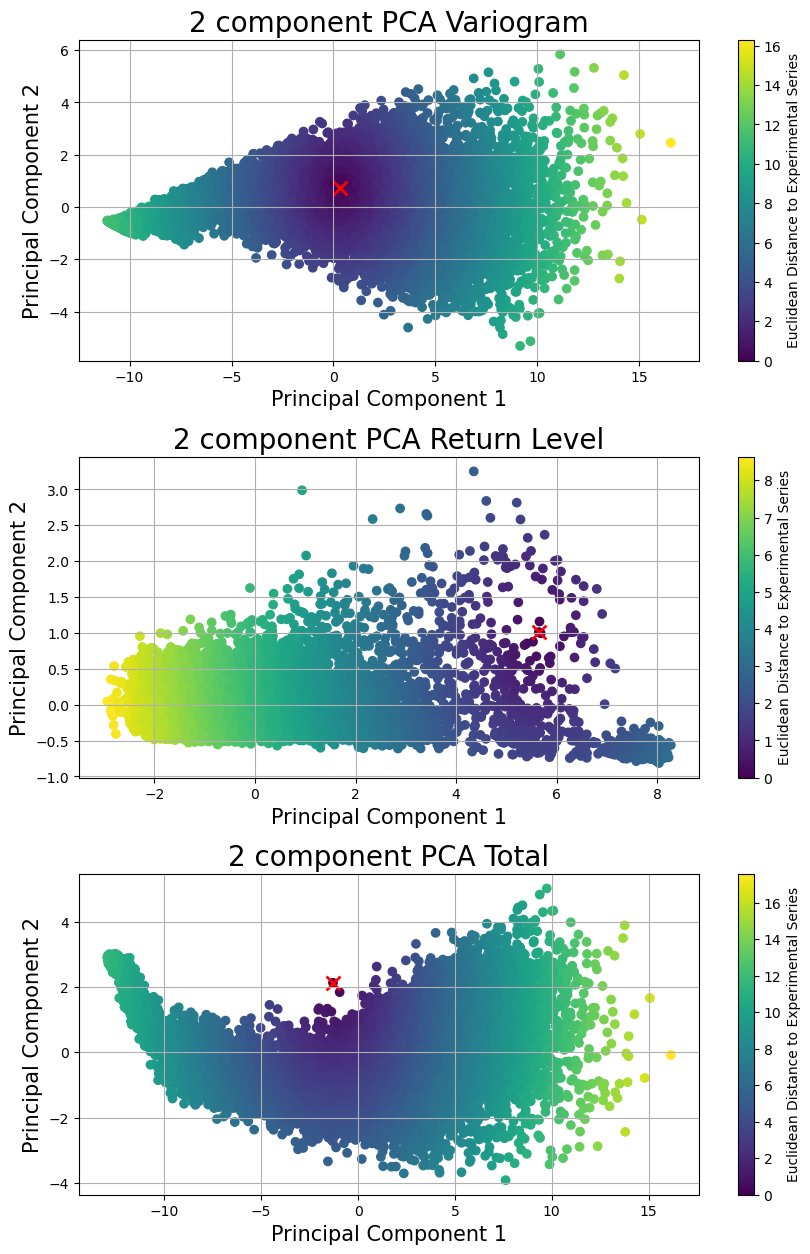

In [4]:
##################### PARAMETERS OF THE COMPARISON ########################################
timelag_max = 20
returnP_min = 51

###################### DO PCA FOR THE VARIOGRAM + COMPUTE EUCLIDEAN DISTANCE ##############################
# Filter the range of values to compare 
variogramExpCropped = [vario for i, vario in enumerate(variogramExp) if timelag[i] <= timelag_max]

# Create the matrix 
matrix_variogram = np.vstack([variogramExpCropped])
for i in range(numFolders):
    # Combine the experimental and synthetic statistics
    matrix_variogram = np.vstack([matrix_variogram, [vario for k, vario in enumerate(variogramList[i]) if timelag[k] <= timelag_max]])

# Convert the matrix into a dataframe
matrix_variogram = pd.DataFrame(matrix_variogram) # Changed to DataFrame
matrix_variogram = StandardScaler().fit_transform(matrix_variogram)

# Perform PCA
pca = PCA(n_components=2)
principalComponentsVariogram = pca.fit_transform(matrix_variogram)
principalDfVariogram = pd.DataFrame(data = principalComponentsVariogram, columns = ['principal component 1', 'principal component 2'])

# Compute Euclidean distances
distancesVariogram = [0]
for i in range(1, len(principalDfVariogram)):
    dist = distance.euclidean(principalDfVariogram.iloc[0], principalDfVariogram.iloc[i])
    distancesVariogram.append(dist)

######################## DO THE SAME FOR RETURN LEVEL ##############################
# Filter the range of values to compare 
returnLevelExpCropped = [level for k, level in enumerate(returnLevelExp) if returnPeriodExp[k] >= returnP_min]

# Create the matrix 
matrix_level = np.vstack([returnLevelExpCropped])
for i in range(numFolders):
    # Combine the experimental and synthetic statistics
    matrix_level = np.vstack([matrix_level, [level for k, level in enumerate(returnLevel[i]) if returnPeriod[i][k] >= returnP_min]])
    
# Convert the matrix into a dataframe
matrix_level = pd.DataFrame(matrix_level) # Changed to DataFrame
matrix_level = StandardScaler().fit_transform(matrix_level)

# Perform PCA
pca = PCA(n_components=2)
principalComponentsLevel = pca.fit_transform(matrix_level)
principalDfLevel = pd.DataFrame(data = principalComponentsLevel, columns = ['principal component 1', 'principal component 2'])

# Compute Euclidean distances
distancesLevel = [0]
for i in range(1, len(principalDfLevel)):
    dist = distance.euclidean(principalDfLevel.iloc[0], principalDfLevel.iloc[i])
    distancesLevel.append(dist)

######################## DO THE SAME FOR BOTH OF THEM ##############################
# Create the full matrix
matrix_total = np.hstack([matrix_level,matrix_variogram])
    
# Convert the matrix into a dataframe
matrix_total = pd.DataFrame(matrix_total) # Changed to DataFrame
matrix_total = StandardScaler().fit_transform(matrix_total)

# Perform PCA
pca = PCA(n_components=2)
principalComponentsTotal = pca.fit_transform(matrix_total)
principalDfTotal = pd.DataFrame(data = principalComponentsTotal, columns = ['principal component 1', 'principal component 2'])

# Compute Euclidean distances
distancesTotal = [0]
for i in range(1, len(principalDfTotal)):
    dist = distance.euclidean(principalDfTotal.iloc[0], principalDfTotal.iloc[i])
    distancesTotal.append(dist)


######################## PLOT  #########################
fig, ax = plt.subplots(3, 1, figsize=(10, 15))
plt.subplots_adjust(hspace=0.3)
ax[0].set_xlabel('Principal Component 1', fontsize = 15)
ax[0].set_ylabel('Principal Component 2', fontsize = 15)
ax[0].set_title('2 component PCA Variogram', fontsize = 20)
scatter = ax[0].scatter(principalDfVariogram['principal component 1'], principalDfVariogram['principal component 2'], c=distancesVariogram, cmap='viridis')
ax[0].scatter(principalDfVariogram['principal component 1'][0], principalDfVariogram['principal component 2'][0], color='red', marker='x', s=100, linewidth=2)
ax[0].grid()
fig.colorbar(scatter, ax=ax[0], label='Euclidean Distance to Experimental Series')

ax[1].set_xlabel('Principal Component 1', fontsize = 15)
ax[1].set_ylabel('Principal Component 2', fontsize = 15)
ax[1].set_title('2 component PCA Return Level', fontsize = 20)
scatter = ax[1].scatter(principalDfLevel['principal component 1'], principalDfLevel['principal component 2'], c=distancesLevel, cmap='viridis')
ax[1].scatter(principalDfLevel['principal component 1'][0], principalDfLevel['principal component 2'][0], color='red', marker='x', s=100, linewidth=2)
ax[1].grid()
fig.colorbar(scatter, ax=ax[1], label='Euclidean Distance to Experimental Series')

ax[2].set_xlabel('Principal Component 1', fontsize = 15)
ax[2].set_ylabel('Principal Component 2', fontsize = 15)
ax[2].set_title('2 component PCA Total', fontsize = 20)
scatter = ax[2].scatter(principalDfTotal['principal component 1'], principalDfTotal['principal component 2'], c=distancesTotal, cmap='viridis')
ax[2].scatter(principalDfTotal['principal component 1'][0], principalDfTotal['principal component 2'][0], color='red', marker='x', s=100, linewidth=2)
ax[2].grid()
fig.colorbar(scatter, ax=ax[2], label='Euclidean Distance to Experimental Series')

plt.show()

The red cross is the position of the experimental time serie. It should be surrounded with points if the parameters of the model are well adapted. 

# Plotting the statistics

## Normalisation of the distances

This is just a step to parametize the distances to have a nice colormap.

In [5]:
# Deleting the first value of the distances to get a better colormap 
distancesVariogramNormalized = [dist/np.max(distancesVariogram[1:]) for dist in distancesVariogram[1:]]
distancesLevelNormalized = [dist/np.max(distancesLevel[1:]) for dist in distancesLevel[1:]]

# Normalize the distances to range between 0 and 1
norm1 = plt.Normalize(min(distancesVariogramNormalized), max(distancesVariogramNormalized))
norm2 = plt.Normalize(min(distancesLevelNormalized), max(distancesLevelNormalized))

## Full plot

This is the part where we plot all the statistics with a colormap that symbolises the distance between the synthetic time serie and the experiment in the PCA space. The blue plots are "close" to the experiment whereas the red ones look less like the experiment. The statistics of the experiment are plot in black.

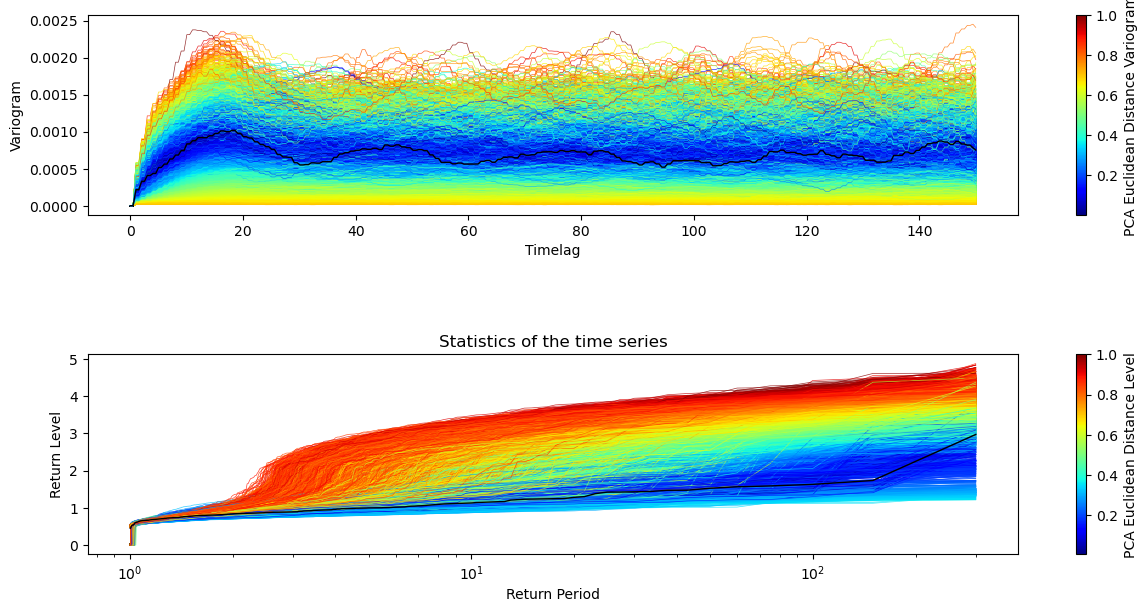

In [6]:
# Choose a colormap
cmap = cm.jet

# Plot the generated statistics
fig, axes = plt.subplots(2, 1, figsize=(15, 7))
plt.subplots_adjust(hspace=0.7)
for i in range(numFolders):
    color1 = cmap(norm1(distancesVariogramNormalized[i]))
    color2 = cmap(norm2(distancesLevelNormalized[i]))
    axes[0].plot(timelag, variogramList[i], c=color1, lw=0.5, alpha=0.8)
    axes[1].semilogx(returnPeriod[i], returnLevel[i], color=color2, lw=0.5, alpha=0.8)

# Plot the experimental statistics
axes[0].plot(timelag, variogramExp, color='black', linewidth=1)
axes[1].semilogx(returnPeriodExp, returnLevelExp, color='black',  linewidth=1)

# Add a colorbar
sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
sm1.set_array([])
sm2.set_array([])
fig.colorbar(sm1, ax=axes[0], label='PCA Euclidean Distance Variogram')
fig.colorbar(sm2, ax=axes[1], label='PCA Euclidean Distance Level')

# Plot legend
axes[0].set_xlabel('Timelag')
axes[0].set_ylabel('Variogram')
axes[1].set_xlabel('Return Period')
axes[1].set_ylabel('Return Level')
plt.title("Statistics of the time series")
plt.show()

## Zoom into the range of comparison

It is relevant to plot the zoom into the range of comparison (so for timelags < `timelag_max` and for return periods > `returnP_min`) to clearly see why the time series that are closer to the experiment than the others.

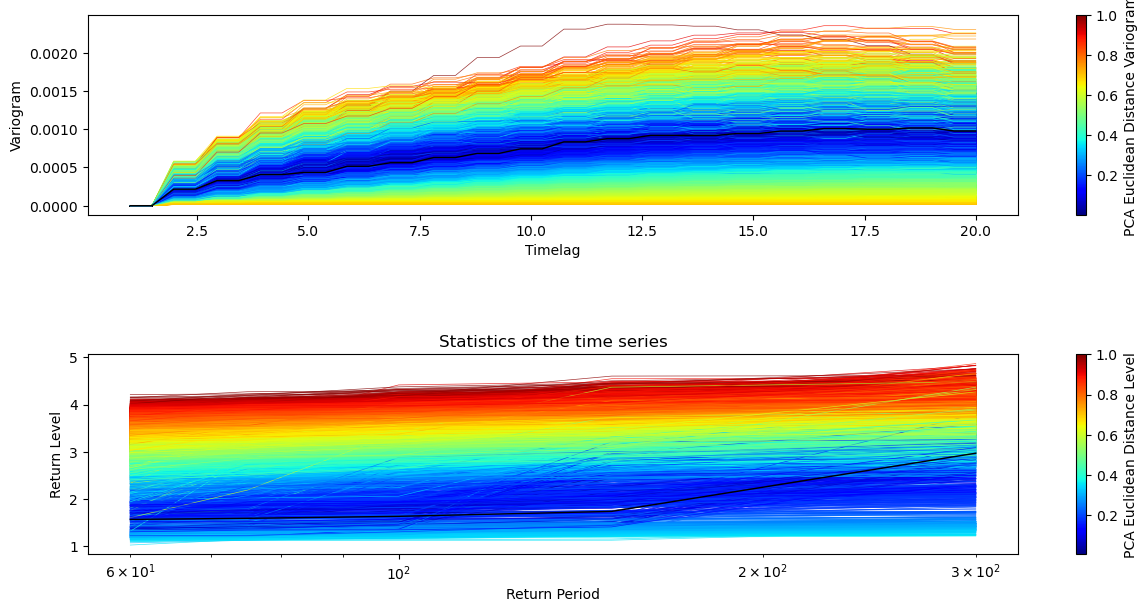

In [84]:
# Plot the generated statistics
fig, axes = plt.subplots(2, 1, figsize=(15, 7))
plt.subplots_adjust(hspace=0.7)
for i in range(numFolders):
    color1 = cmap(norm1(distancesVariogramNormalized[i]))
    color2 = cmap(norm2(distancesLevelNormalized[i]))
    axes[0].plot(np.linspace(1,20,40), [vario for k, vario in enumerate(variogramList[i]) if timelag[k] < timelag_max], c=color1, lw=0.5, alpha=0.8)
    axes[1].semilogx([period for k, period in enumerate(returnPeriod[i]) if period > returnP_min], [level for k, level in enumerate(returnLevel[i]) if returnPeriod[i][k] > returnP_min], color=color2, lw=0.5, alpha=0.8)

# Plot the experimental statistics
axes[0].plot(np.linspace(1,20,40), [vario for k, vario in enumerate(variogramExp) if timelag[k] < timelag_max], color='black', linewidth=1)
axes[1].semilogx([period for k, period in enumerate(returnPeriodExp) if period > returnP_min], [level for k, level in enumerate(returnLevelExp) if returnPeriodExp[k] > returnP_min], color='black',  linewidth=1)

# Add a colorbar
sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
sm1.set_array([])
sm2.set_array([])
fig.colorbar(sm1, ax=axes[0], label='PCA Euclidean Distance Variogram')
fig.colorbar(sm2, ax=axes[1], label='PCA Euclidean Distance Level')

# Plot legend
axes[0].set_xlabel('Timelag')
axes[0].set_ylabel('Variogram')
axes[1].set_xlabel('Return Period')
axes[1].set_ylabel('Return Level')
plt.title("Statistics of the time series")
plt.show()


# Acceptance process

## Plotting the accepted time series

### Setting the number of accepted time series

We set the number of accepted time series that we want and the code automatically increases `epsilon` until it gets the good number of validated time series. The treshold is applied for both distances (related to the variogram and the return level). It then plots the statistics just as before with the same colormap.

400 on 10000 time series have been accepted
Epsilon value: 0.49539999999996176


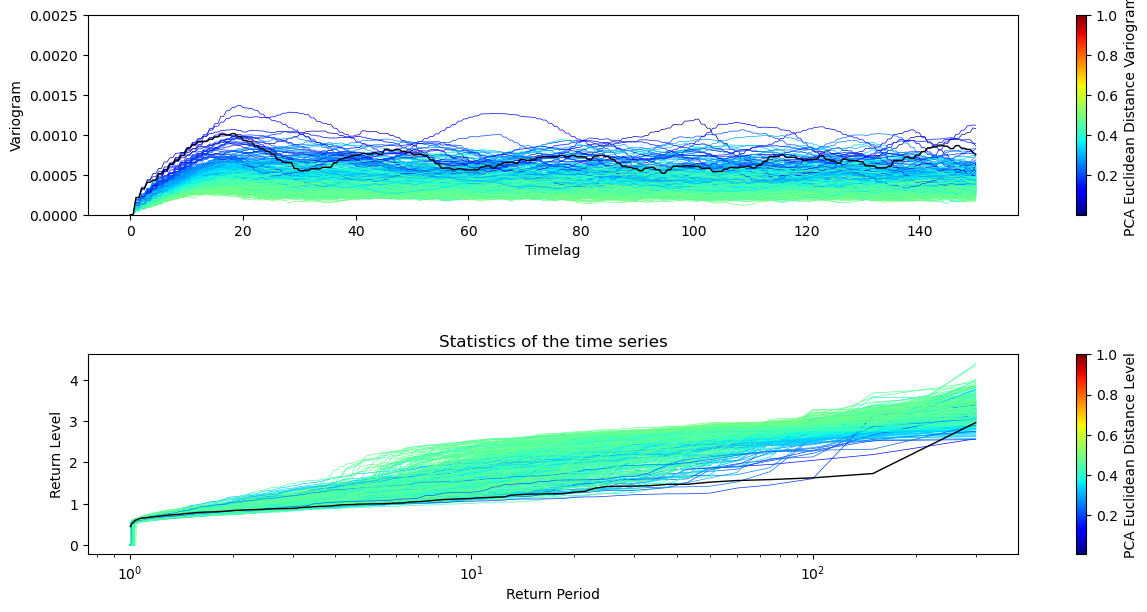

In [16]:
################ CHOOSING THE ACCEPTED TIME SERIES #################################
target_accepted = 400  # the number of accepted series wanted
epsilon = 0  # initialization of epsilon

# Increase epsilon until we get the right number of accepted time series
while True:
    acceptedIndices = [i for i, dist in enumerate(distancesVariogramNormalized) if (dist < epsilon and distancesLevelNormalized[i] < epsilon)]
    if len(acceptedIndices) >= target_accepted:
        break
    
    epsilon += 0.0001  

# Get the accepted statistics
acceptedVariogram = [variogramList[acceptedIndices[i]] for i in range(len(acceptedIndices))]
acceptedLevel = [returnLevel[acceptedIndices[i]] for i in range(len(acceptedIndices))]
acceptedPeriod = [returnPeriod[acceptedIndices[i]] for i in range(len(acceptedIndices))]
print(f"{len(acceptedIndices)} on {len(variogramList)} time series have been accepted")
print(f"Epsilon value: {epsilon}")

# Get the accepted distances
acceptedDistancesVariogram = [distancesVariogramNormalized[acceptedIndices[i]] for i in range(len(acceptedIndices))]
acceptedDistancesLevel = [distancesLevelNormalized[acceptedIndices[i]] for i in range(len(acceptedIndices))]

# Normalize the distances to range between 0 and 1
norm1 = plt.Normalize(min(distancesVariogramNormalized), max(distancesVariogramNormalized))
norm2 = plt.Normalize(min(distancesLevelNormalized), max(distancesLevelNormalized))

####################### PLOT ############################
# Plot the accepted statistics
fig, axes = plt.subplots(2, 1, figsize=(15, 7))
plt.subplots_adjust(hspace=0.7)
for i in range(len(acceptedIndices)):
    color1 = cmap(norm1(acceptedDistancesVariogram[i]))
    color2 = cmap(norm2(acceptedDistancesLevel[i]))
    axes[0].plot(timelag, acceptedVariogram[i], c=color1, lw=0.5)
    axes[1].semilogx(acceptedPeriod[i], acceptedLevel[i], color=color2, lw=0.5)

# Plot the experimental statistics
axes[0].plot(timelag, variogramExp, color='black', linewidth=1)
axes[1].semilogx(returnPeriodExp, returnLevelExp, color='black',  linewidth=1)

# Add a colorbar
sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
sm1.set_array([])
sm2.set_array([])
fig.colorbar(sm1, ax=axes[0], label='PCA Euclidean Distance Variogram')
fig.colorbar(sm2, ax=axes[1], label='PCA Euclidean Distance Level')

# Plot legend
axes[0].set_xlabel('Timelag')
axes[0].set_ylabel('Variogram')
axes[1].set_xlabel('Return Period')
axes[0].set_ylim((0,2.5E-3))
axes[1].set_ylabel('Return Level')
plt.title("Statistics of the time series")
plt.show()


### Setting the tresholds

An other way of selecting good time series is to set the tresholds below which we accept a time serie or not. As there are two distances, there is a treshold for each. As a consequence, we can play with those two tresholds to be more restrictive on the return level than on the variogram for example.

192 on 1000 time series have been accepted
Epsilon value: 0.5198999999999591


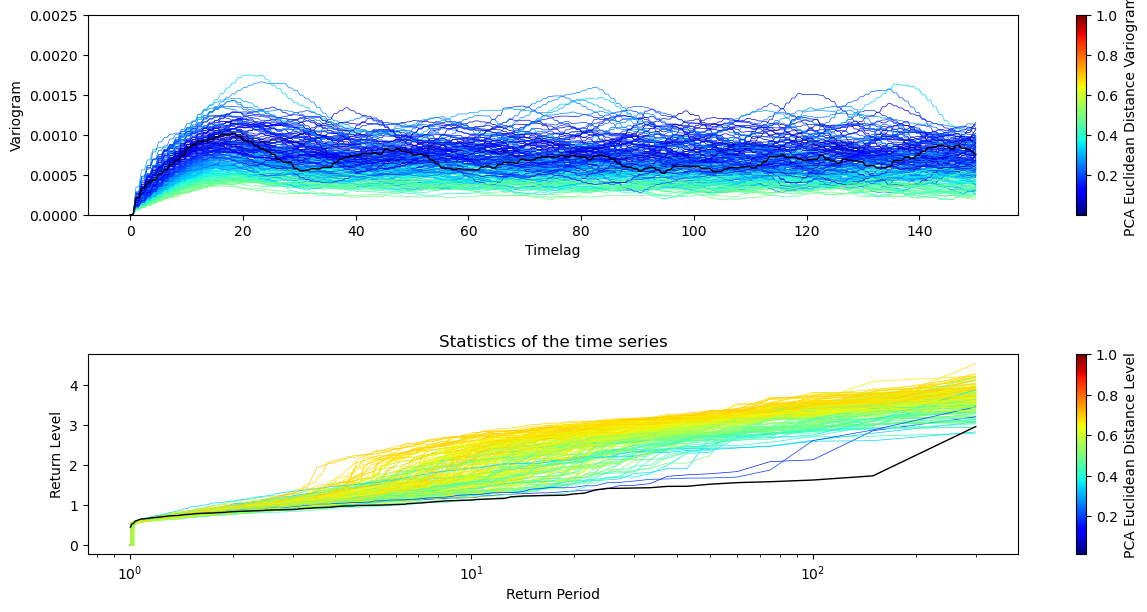

In [37]:
################ CHOOSING THE TRESHOLDS #################################
# Setting the treshold for the two distances
epsilon_variogram = 0.5
epsilon_returnLevel = 0.7

acceptedIndices = [i for i, dist in enumerate(distancesVariogramNormalized) if (dist < epsilon_variogram and distancesLevelNormalized[i] < epsilon_returnLevel)]

# Get the accepted statistics
acceptedVariogram = [variogramList[acceptedIndices[i]] for i in range(len(acceptedIndices))]
acceptedLevel = [returnLevel[acceptedIndices[i]] for i in range(len(acceptedIndices))]
acceptedPeriod = [returnPeriod[acceptedIndices[i]] for i in range(len(acceptedIndices))]
print(f"{len(acceptedIndices)} on {len(variogramList)} time series have been accepted")
print(f"Epsilon value: {epsilon}")

# Get the accepted distances
acceptedDistancesVariogram = [distancesVariogramNormalized[acceptedIndices[i]] for i in range(len(acceptedIndices))]
acceptedDistancesLevel = [distancesLevelNormalized[acceptedIndices[i]] for i in range(len(acceptedIndices))]

# Normalize the distances to range between 0 and 1
norm1 = plt.Normalize(min(distancesVariogramNormalized), max(distancesVariogramNormalized))
norm2 = plt.Normalize(min(distancesLevelNormalized), max(distancesLevelNormalized))

####################### PLOT ############################
# Plot the accepted statistics
fig, axes = plt.subplots(2, 1, figsize=(15, 7))
plt.subplots_adjust(hspace=0.7)
for i in range(len(acceptedIndices)):
    color1 = cmap(norm1(acceptedDistancesVariogram[i]))
    color2 = cmap(norm2(acceptedDistancesLevel[i]))
    axes[0].plot(timelag, acceptedVariogram[i], c=color1, lw=0.5)
    axes[1].semilogx(acceptedPeriod[i], acceptedLevel[i], color=color2, lw=0.5)

# Plot the experimental statistics
axes[0].plot(timelag, variogramExp, color='black', linewidth=1)
axes[1].semilogx(returnPeriodExp, returnLevelExp, color='black',  linewidth=1)

# Add a colorbar
sm1 = cm.ScalarMappable(cmap=cmap, norm=norm1)
sm2 = cm.ScalarMappable(cmap=cmap, norm=norm2)
sm1.set_array([])
sm2.set_array([])
fig.colorbar(sm1, ax=axes[0], label='PCA Euclidean Distance Variogram')
fig.colorbar(sm2, ax=axes[1], label='PCA Euclidean Distance Level')

# Plot legend
axes[0].set_xlabel('Timelag')
axes[0].set_ylabel('Variogram')
axes[1].set_xlabel('Return Period')
axes[0].set_ylim((0,2.5E-3))
axes[1].set_ylabel('Return Level')
plt.title("Statistics of the time series")
plt.show()


## Scatter plot of the accepted stochastic parameters

This is the final goal of the process : get the range of accepted values for the two stochastic parameters of the model. If everything is going well, the scatter plot should show a region of acceptance that should be interpreted. In J. Hoffimann's paper, there are two regions of acceptance that he found : low sigma and high lambda (basically frequent small morphological changes) and high sigma and low lambda (a few big morphological changes).

The acceptance region depends a lot on the range of values that you choose for sigma and lambda. It is recommended to set a wide range of values so that we identify well the region and that we do not miss out an other region.

We can change the `alpha` parameter to make the rejected time series appear in red. 

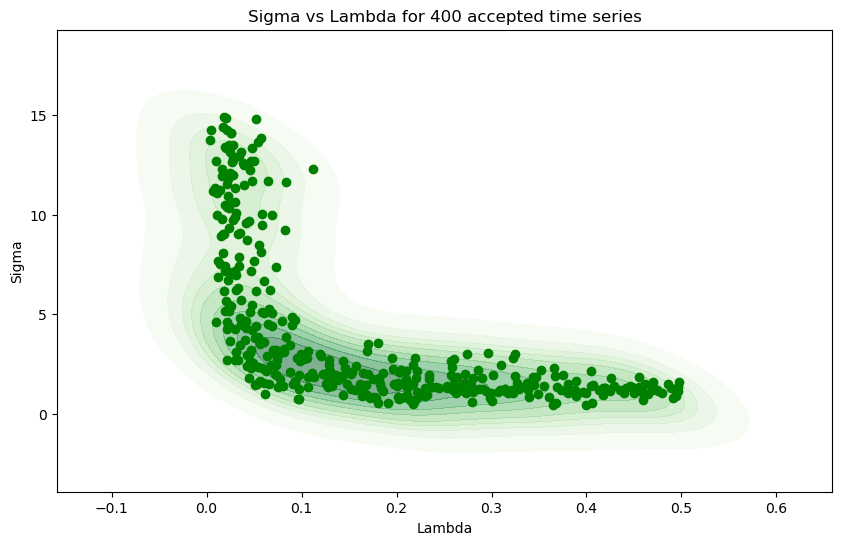

In [17]:
# Get accepted values of sigma and lambda
acceptedSigma = [sigma_values[acceptedIndices[i]] for i in range(len(acceptedIndices))]
acceptedLambda = [lambda_values[acceptedIndices[i]] for i in range(len(acceptedIndices))]

# Generate a color for each series
colors = ["red"] * numFolders
for i in acceptedIndices:
    colors[i] = "green"

# Create the KDE plot
plt.figure(figsize=(10, 6))
sns.kdeplot(x=acceptedLambda, y=acceptedSigma, cmap="Greens", fill=True, levels=10, bw_adjust=1, alpha=0.5)

# Scatter plot with the corresponding colors
plt.scatter(lambda_values, sigma_values, c=colors, alpha=0) # Change the transparency to plot the rejected time series 
for i in range(len(acceptedIndices)):
    plt.scatter(acceptedLambda[i], acceptedSigma[i], c="green")  

plt.xlabel('Lambda')
plt.ylabel('Sigma')
plt.title(f'Sigma vs Lambda for {len(acceptedIndices)} accepted time series')
plt.show()

## Histograms

### Experimental time serie

We plot the histogram of the consecutive MHD of the experimental time serie to see the distribution of values. We want to compare it with the histogram of the accepted synthetic time series.

Text(0, 0.5, 'Frequency')

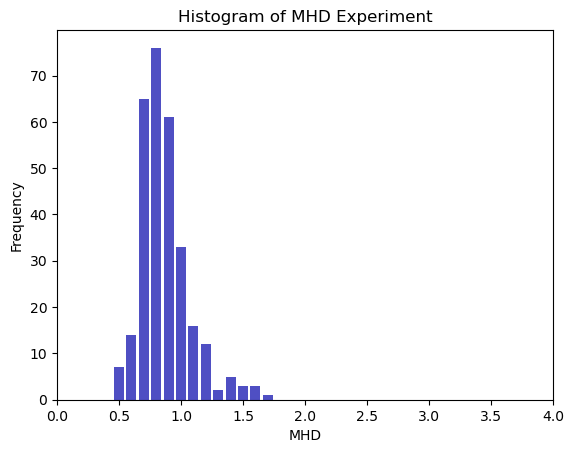

In [9]:
# Histogram of the experiment
min_s = min(MHDExp)
max_s = max(MHDExp)
bin_s = np.arange(min_s, max_s, 0.1) 
plt.hist(MHDExp, bins=bin_s, color='#0504aa', alpha=0.7, rwidth=0.8)
plt.title('Histogram of MHD Experiment')
plt.xlabel('MHD')
plt.xlim([0,4])
plt.ylabel('Frequency')

### Accepted time series

We plot the histogram of the consecutive MHD of all of the accepted time series. It should look like the histogram of the experiment.

Text(0, 0.5, 'Frequency')

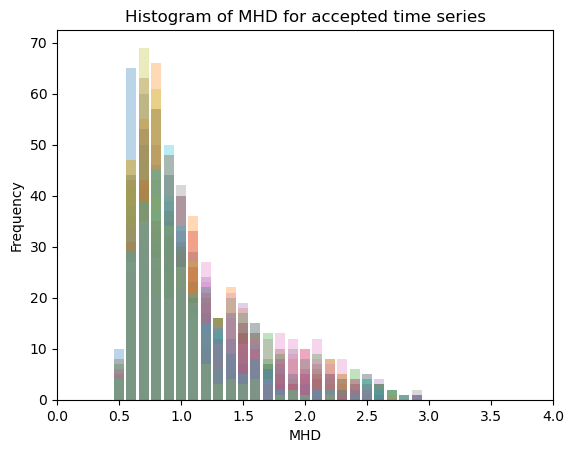

In [15]:
# Histogram of the validated time series
min_s = min(MHDExp)
max_s = max(MHDExp)
bin_s = np.arange(min_s, max_s, 0.1) 
for i in acceptedIndices:
    plt.hist(MHD[i], bins=bin_s, alpha=0.3, rwidth=0.8)
plt.title('Histogram of MHD for accepted time series')
plt.xlabel('MHD')
plt.xlim([0.0,4])
plt.ylabel('Frequency')

## Consecutive MHD

Here is an interesting part : we plot the consecutive MHD with time for the experiment and one random accepted time serie. As we run multiple times the cell, we can see 
two cases for the accepted time series : a lot of 'small' consecutive changes or a few 'high' changes.

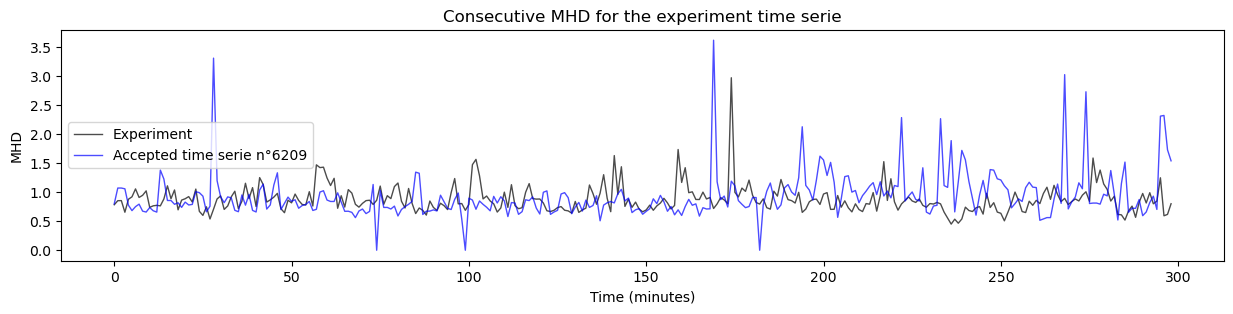

In [29]:
# Get the index of a random accepted time serie
random_index = random.choice(acceptedIndices)

# Plot the consecutive MHD for the experiment and one random accepted time serie
plt.figure(figsize=(15,3))
plt.plot(MHDExp, label="Experiment", color='black', lw=1, alpha=0.7)
plt.plot(MHD[random_index], label=f'Accepted time serie n°{random_index}', color='blue', lw=1, alpha=0.7)
plt.title('Consecutive MHD for the experiment time serie')
plt.xlabel('Time (minutes)')
plt.ylabel('MHD')
plt.legend()
plt.show()

# Extreme value index

We compute the extreme value indices for all the time series and plot the histogram for one number of maxima. We just want to check that the experiment belongs in the same range as the generated time series.

In [32]:
# Compute the extreme value indices for the experiment 
start_time = time.time()
eviExpList = f.calculate_extreme_value_index(MHDExp)

# Extreme value indices for the synthetic time series
eviSyntheticList = [[0]*(T-1) for _ in range(numFolders)]
for k in range(len(MHD)):
    evi = f.calculate_extreme_value_index(MHD[k])
    eviSyntheticList[k] = evi
    
# Computes the time the programm took to run
end_time = time.time()
duration = end_time - start_time
print(f"The code took {duration} secondes to run.")

The code took 30.907719373703003 secondes to run.


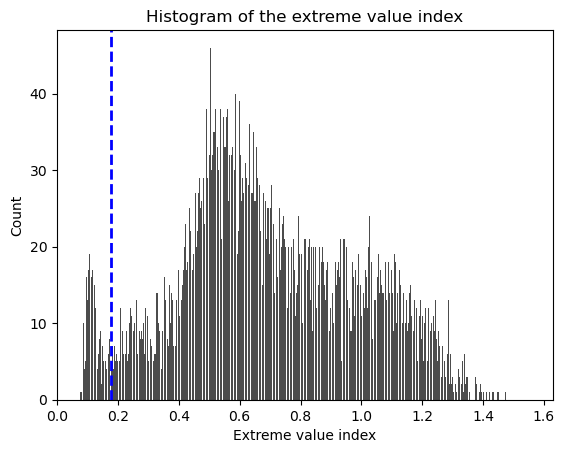

In [41]:
# Choose the number of maxima retained (25 in the paper)
numMaxima = 60

# Get the extreme value index at the number of maxima retained
eviExp = eviExpList[numMaxima]
eviSynthetic = [eviSyntheticList[k][numMaxima] for k in range(numFolders)]

# Plot the histogram
min_s = min(eviSynthetic)
max_s = max(eviSynthetic)
bin_s = np.arange(min_s, max_s, 0.002) 
plt.hist(eviSynthetic, bins=bin_s, color='black', alpha=0.7, rwidth=0.8)
plt.axvline(x=eviExp, color='blue', linestyle='dashed', linewidth=2)
plt.title('Histogram of the extreme value index')
plt.xlabel('Extreme value index')
plt.ylabel('Count')
plt.show()